## Install Libraries

In [ ]:
!pip install -q ezyquant
!pip install -q quantstats # for visualization

## Import libraries

In [ ]:
import ezyquant as ez
from ezyquant import fields as fld
from ezyquant.backtesting import Context
from ezyquant.reader import _SETDataReaderCached

import quantstats as qs
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# google authen
from google.colab import drive

drive.mount("/content/drive")

# connect DB
database_path = "/content/drive/MyDrive/DB/ezyquant.db"
ez.connect_sqlite(database_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
start_data = "2008-01-01"  # import data
start_date = "2010-01-01"  # backtest and report
end_date = _SETDataReaderCached().last_update()

# SET

In [ ]:
UNIVERSE = ["SET"]

ssc = ez.SETSignalCreator(
    start_date=start_data,
    end_date=end_date,
    index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
    field=fld.D_INDEX_CLOSE,
    index_list=[fld.MARKET_SET],
    start_date=start_data,
    end_date=end_date,
)

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)

## Solution 1

### Screening Conditions

- RSI(14) < 30
- Netprofit Growth(%QoQ) 1 Quarter
- Netprofit Growth(%QoQY) 1 Quarter

Ranking: top 10 %Net profit Growth QoQY 1 Quarter + rebalance monthly

In [ ]:
MODEL_NAME = "Nearing End of Downtrend"

close_df = ssc.get_data(field="close", timeframe="daily")
value_df = ssc.get_data(field="value", timeframe="daily")
rsi_df = ssc.ta.rsi(close_df, 14)
# netprofit
net_profit_df = ssc.get_data(field="net_profit", timeframe="quarterly")
# netprofit QoQ
net_profit_shift_df = ssc.get_data(field="net_profit", timeframe="quarterly", shift=1)
# netprofit QoQY
net_profit_shift_4_df = ssc.get_data(field="net_profit", timeframe="quarterly", shift=4)

# Netprofit Growth(%QoQ) 1 Quarter
npg_percent_qoq_df = net_profit_df / net_profit_shift_df

# Netprofit Growth(%QoQY) 1 Quarter
npg_percent_qoqy_df = net_profit_df / net_profit_shift_4_df

In [ ]:
# screening condition
rsi_cond = rsi_df < 30
npg_percent_qoq_cond = npg_percent_qoq_df > 0
value_cond = value_df.rolling(window=20).mean() > 2e7  # volume > 2e7

signal_cond = rsi_cond & npg_percent_qoq_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)

In [ ]:
def screen_npg_percent_qoqy_df(
    signal_df: pd.DataFrame, net_proft_growth_qoq_df: pd.DataFrame
) -> pd.DataFrame:
    return pd.DataFrame(
        np.where((signal_df == True), net_proft_growth_qoq_df, np.nan),
        columns=signal_df.columns,
        index=signal_df.index,
    )

In [ ]:
# %netprofit growth QoQy
# 10 highest %netprofit growth QoQy
npg_percent_qoqy_df = screen_npg_percent_qoqy_df(signal_df, npg_percent_qoqy_df)
npg_percent_rank_df = ssc.rank(
    factor_df=npg_percent_qoqy_df, quantity=10, ascending=False
)

In [ ]:
from ezyquant.utils import is_rebalance_monthly

pos_num = 10
signal_trade = (npg_percent_rank_df > 0) & (npg_percent_rank_df <= pos_num)

# -- rebalance signal --
rebalance_date = is_rebalance_monthly(close_df.index, 31)
signal_trade = signal_trade.mask(~rebalance_date, np.nan)

# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(
    np.where(lookahead_signal == -1, -1, signal_trade),
    columns=signal_trade.columns,
    index=signal_trade.index,
)

### Backtest Algorithm

In [ ]:
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0:
        return c.target_pct_port(1 / pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0)  # sell
    return 0


# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)

### Visualization

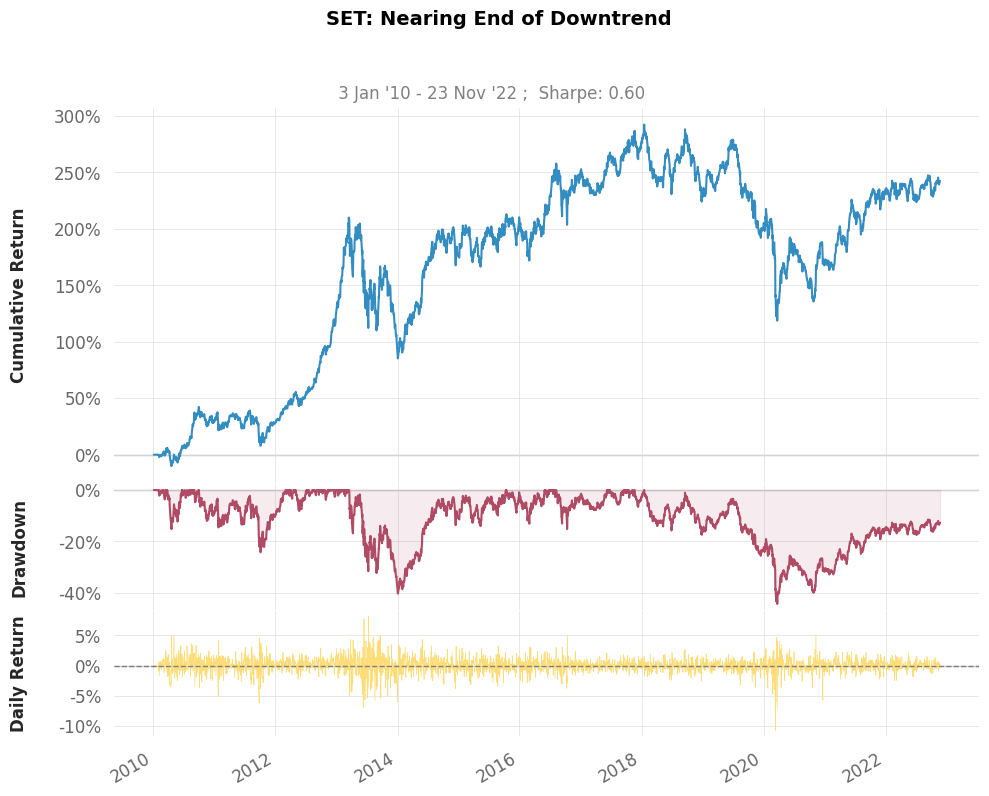

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   242.43%     121.83%
CAGR﹪              10.02%      6.37%

Sharpe              0.6         0.47
Prob. Sharpe Ratio  98.18%      95.09%
Sortino             0.84        0.65
Sortino/√2          0.59        0.46
Omega               1.11        1.11

Max Drawdown        -44.27%     -44.29%
Longest DD Days     1770        1763

Gain/Pain Ratio     0.11        0.09
Gain/Pain (1M)      0.55        0.44

Payoff Ratio        0.96        0.92
Profit Factor       1.11        1.09
Common Sense Ratio  1.17        1.06
CPC Index           0.56        0.54
Tail Ratio          1.05        0.97
Outlier Win Ratio   3.35        4.32
Outlier Loss Ratio  3.74        4.54

MTD                 0.62%       0.97%
3M         

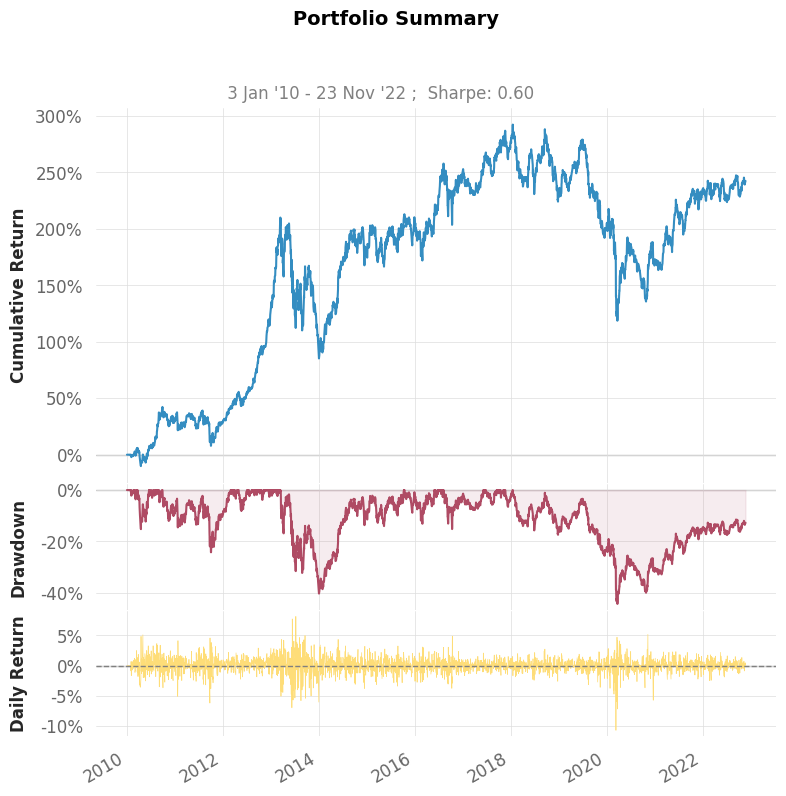

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


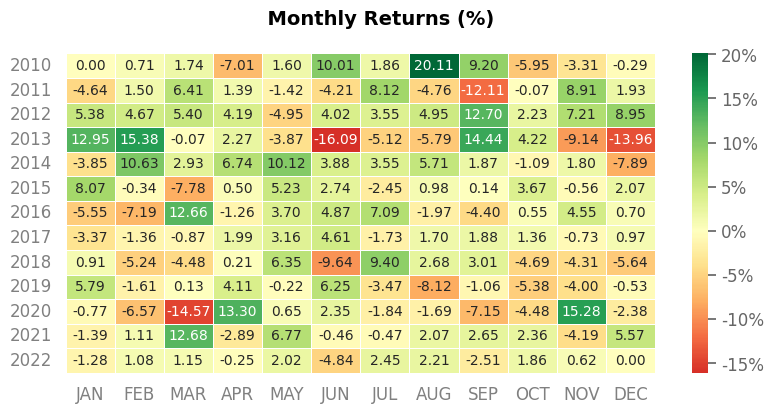

In [ ]:
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(
    summary_df["port_value_with_dividend"], title=f"{UNIVERSE[0]}: {MODEL_NAME}"
)
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])

## Solution 2

### Screening Conditions

- RSI(14) < 30
- Netprofit Growth(%QoQ) 1 Quarter
- Netprofit Growth(%QoQY) 1 Quarter

Ranking: top 40 stock with the highest net profit QoQ 1Q + 20 stock net profit QoQY 1Q + rebalance monthly

In [ ]:
# netprofit growth QoQ
net_proft_growth_qoq_df = net_profit_df / net_profit_shift_df

# netprofit growth QoQ
net_proft_growth_qoqy_df = net_profit_df / net_profit_shift_4_df

In [ ]:
# screening condition
rsi_cond = rsi_df < 30
value_cond = value_df.rolling(window=20).mean() > 2e7  # volume > 2e7

signal_cond = rsi_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)

In [ ]:
def screen_net_profit_growth_qoq(
    signal_df: pd.DataFrame, net_proft_growth_qoq_df: pd.DataFrame
) -> pd.DataFrame:
    return pd.DataFrame(
        np.where((signal_df == True), net_proft_growth_qoq_df, np.nan),
        columns=signal_df.columns,
        index=signal_df.index,
    )


def screen_net_profit_growth_qoqy(
    qoq_rank_df: pd.DataFrame, qoq_num: int, net_proft_growth_qoqy_df: pd.DataFrame
) -> pd.DataFrame:
    return pd.DataFrame(
        np.where((qoq_rank_df <= qoq_num), net_proft_growth_qoqy_df, np.nan),
        columns=qoq_rank_df.columns,
        index=qoq_rank_df.index,
    )

In [ ]:
# net profit growth(%QoQ) 1 quarter
# 40 highest net profit growth(%QoQ) 1 quarter
qoq_df = screen_net_profit_growth_qoq(signal_df, net_proft_growth_qoq_df)
qoq_rank_df = ssc.rank(factor_df=qoq_df, quantity=40, ascending=False)

# net profit growth(%QoQY) 1 quarter
# 20 highest net profit growth(%QoQY) 1 quarter
qoqy_df = screen_net_profit_growth_qoqy(
    qoq_rank_df=qoq_rank_df,
    qoq_num=10,
    net_proft_growth_qoqy_df=net_proft_growth_qoqy_df,
)
qoqy_rank_df = ssc.rank(factor_df=qoqy_df, quantity=20, ascending=False)

In [ ]:
from ezyquant.utils import is_rebalance_monthly

pos_num = 10
signal_trade = (qoqy_rank_df > 0) & (qoqy_rank_df <= pos_num)

# -- rebalance signal --
rebalance_date = is_rebalance_monthly(close_df.index, 31)
signal_trade = signal_trade.mask(~rebalance_date, np.nan)

In [ ]:
# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(
    np.where(lookahead_signal == -1, -1, signal_trade),
    columns=signal_trade.columns,
    index=signal_trade.index,
)

### Backtest Algorithm

In [ ]:
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0:
        return c.target_pct_port(1 / pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0)  # sell
    return 0


# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)

### Visualization

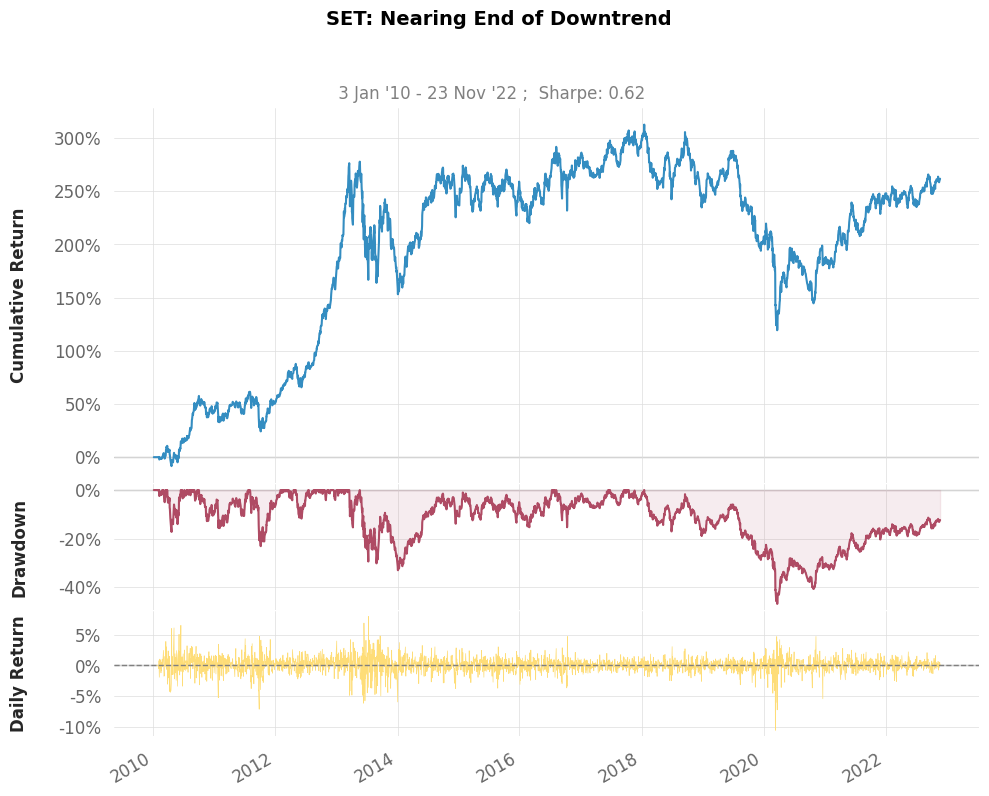

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   261.76%     121.83%
CAGR﹪              10.49%      6.37%

Sharpe              0.62        0.47
Prob. Sharpe Ratio  98.5%       95.09%
Sortino             0.87        0.65
Sortino/√2          0.62        0.46
Omega               1.12        1.12

Max Drawdown        -46.85%     -44.29%
Longest DD Days     1770        1763

Gain/Pain Ratio     0.12        0.09
Gain/Pain (1M)      0.56        0.44

Payoff Ratio        0.95        0.92
Profit Factor       1.12        1.09
Common Sense Ratio  1.15        1.06
CPC Index           0.56        0.54
Tail Ratio          1.03        0.97
Outlier Win Ratio   3.34        4.28
Outlier Loss Ratio  3.79        4.59

MTD                 0.81%       0.97%
3M         

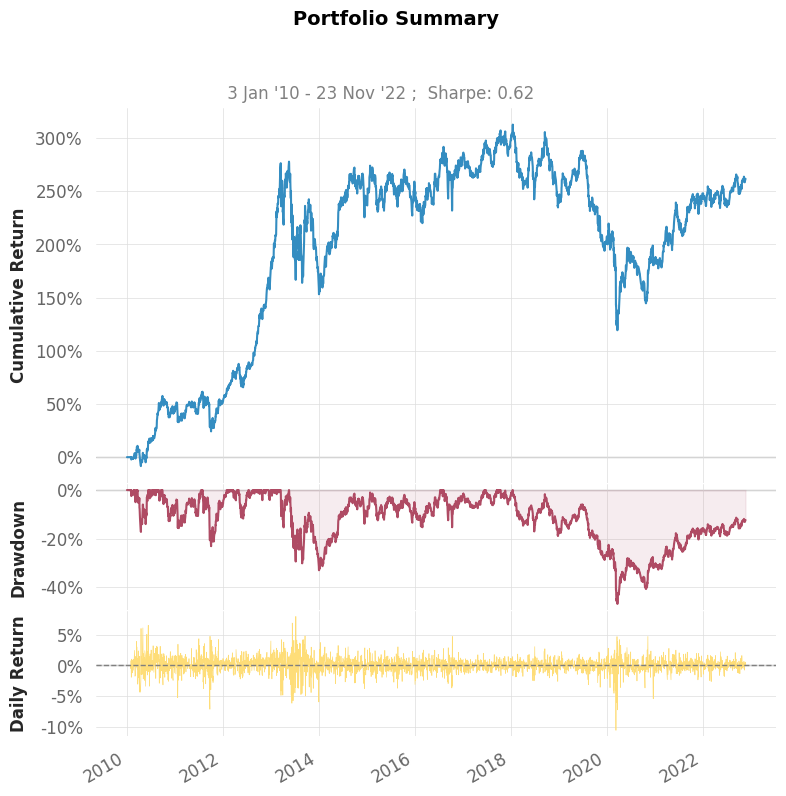

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


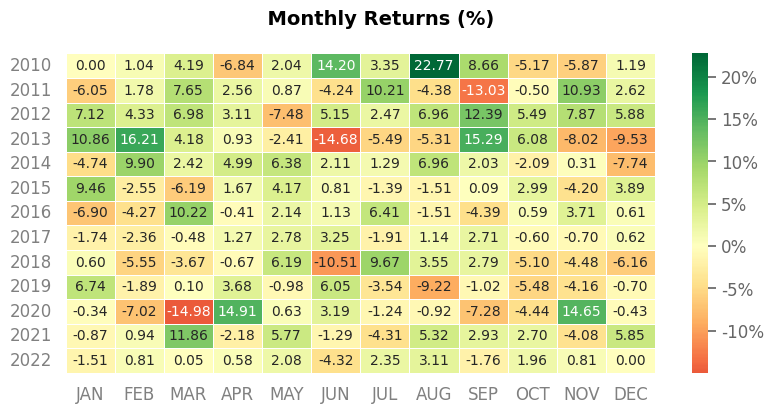

In [ ]:
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(
    summary_df["port_value_with_dividend"], title=f"{UNIVERSE[0]}: {MODEL_NAME}"
)
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])

# SET100

## Solution 1

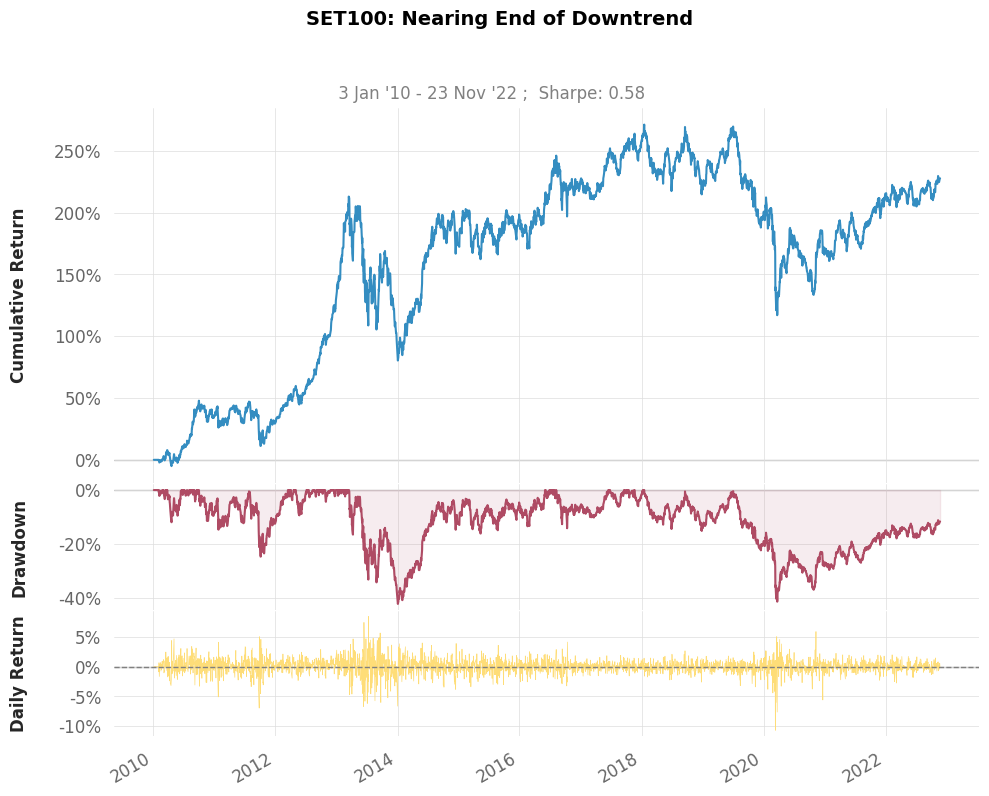

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   227.64%     121.83%
CAGR﹪              9.64%       6.37%

Sharpe              0.58        0.47
Prob. Sharpe Ratio  97.83%      95.09%
Sortino             0.81        0.65
Sortino/√2          0.57        0.46
Omega               1.11        1.11

Max Drawdown        -42.37%     -44.29%
Longest DD Days     1770        1763

Gain/Pain Ratio     0.11        0.09
Gain/Pain (1M)      0.52        0.44

Payoff Ratio        0.92        0.91
Profit Factor       1.11        1.09
Common Sense Ratio  1.12        1.06
CPC Index           0.55        0.54
Tail Ratio          1.01        0.97
Outlier Win Ratio   3.47        4.4
Outlier Loss Ratio  3.69        4.58

MTD                 1.29%       0.97%
3M          

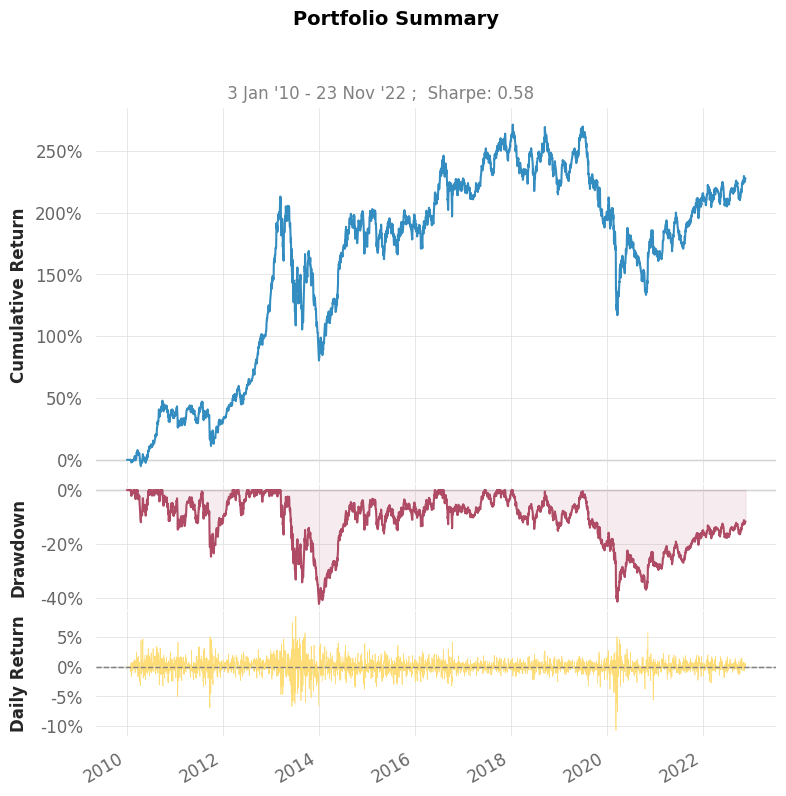

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


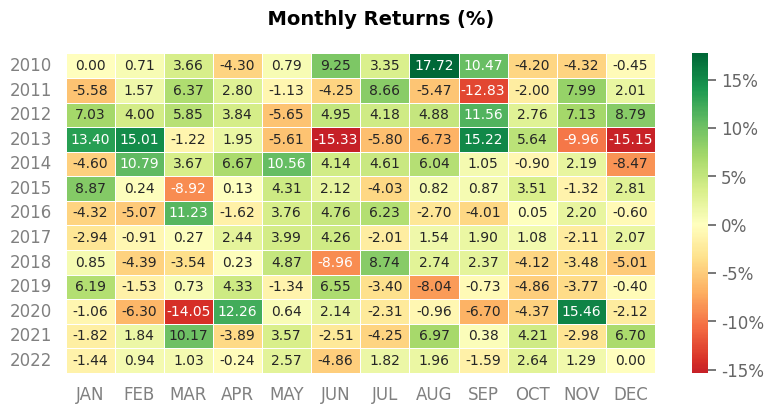

In [ ]:
UNIVERSE = ["SET100"]

ssc = ez.SETSignalCreator(
    start_date=start_data,
    end_date=end_date,
    index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
    field=fld.D_INDEX_CLOSE,
    index_list=[fld.MARKET_SET],
    start_date=start_data,
    end_date=end_date,
)

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)
MODEL_NAME = "Nearing End of Downtrend"

close_df = ssc.get_data(field="close", timeframe="daily")
value_df = ssc.get_data(field="value", timeframe="daily")
rsi_df = ssc.ta.rsi(close_df, 14)
# netprofit
net_profit_df = ssc.get_data(field="net_profit", timeframe="quarterly")
# netprofit QoQ
net_profit_shift_df = ssc.get_data(field="net_profit", timeframe="quarterly", shift=1)
# netprofit QoQY
net_profit_shift_4_df = ssc.get_data(field="net_profit", timeframe="quarterly", shift=4)

# Netprofit Growth(%QoQ) 1 Quarter
npg_percent_qoq_df = net_profit_df / net_profit_shift_df

# Netprofit Growth(%QoQY) 1 Quarter
npg_percent_qoqy_df = net_profit_df / net_profit_shift_4_df
# screening condition
rsi_cond = rsi_df < 30
npg_percent_qoq_cond = npg_percent_qoq_df > 0
value_cond = value_df.rolling(window=20).mean() > 2e7  # volume > 2e7

signal_cond = rsi_cond & npg_percent_qoq_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)


def screen_npg_percent_qoqy_df(
    signal_df: pd.DataFrame, net_proft_growth_qoq_df: pd.DataFrame
) -> pd.DataFrame:
    return pd.DataFrame(
        np.where((signal_df == True), net_proft_growth_qoq_df, np.nan),
        columns=signal_df.columns,
        index=signal_df.index,
    )


# %netprofit growth QoQy
# 10 highest %netprofit growth QoQy
npg_percent_qoqy_df = screen_npg_percent_qoqy_df(signal_df, npg_percent_qoqy_df)
npg_percent_rank_df = ssc.rank(
    factor_df=npg_percent_qoqy_df, quantity=10, ascending=False
)
from ezyquant.utils import is_rebalance_monthly

pos_num = 10
signal_trade = (npg_percent_rank_df > 0) & (npg_percent_rank_df <= pos_num)

# -- rebalance signal --
rebalance_date = is_rebalance_monthly(close_df.index, 31)
signal_trade = signal_trade.mask(~rebalance_date, np.nan)

# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(
    np.where(lookahead_signal == -1, -1, signal_trade),
    columns=signal_trade.columns,
    index=signal_trade.index,
)


## Backtest Algorithm
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0:
        return c.target_pct_port(1 / pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0)  # sell
    return 0


# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)
## Visualization
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(
    summary_df["port_value_with_dividend"], title=f"{UNIVERSE[0]}: {MODEL_NAME}"
)
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])

## Solution 2

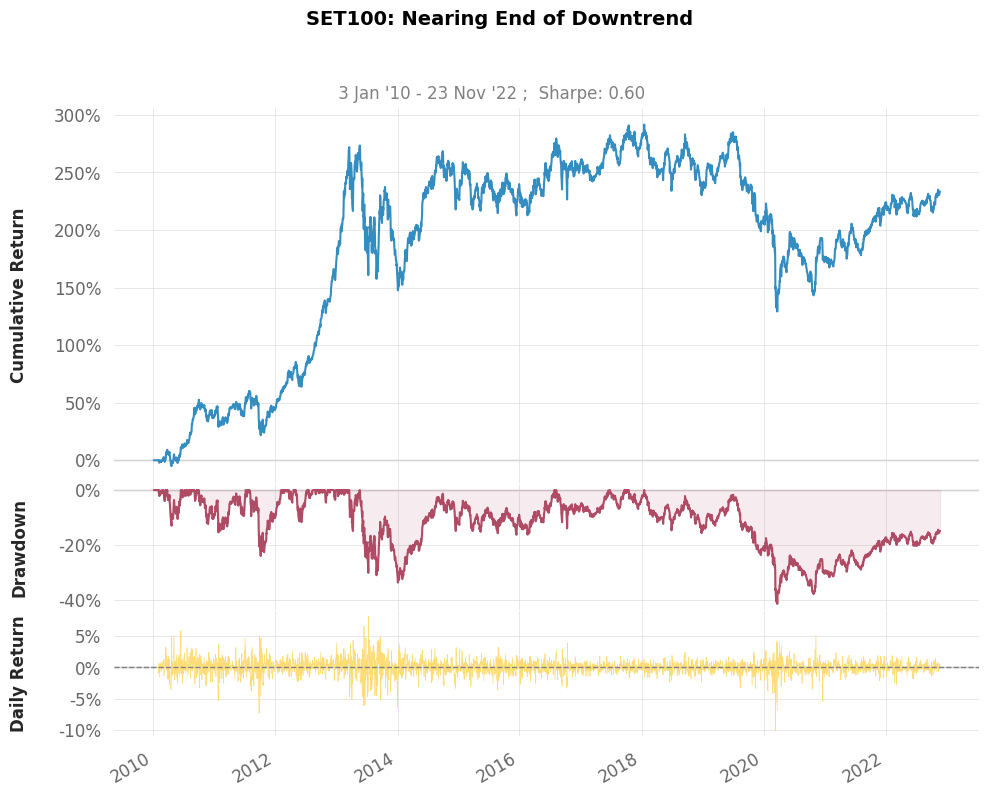

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   233.38%     121.83%
CAGR﹪              9.79%       6.37%

Sharpe              0.6         0.47
Prob. Sharpe Ratio  98.2%       95.09%
Sortino             0.84        0.65
Sortino/√2          0.59        0.46
Omega               1.12        1.12

Max Drawdown        -41.46%     -44.29%
Longest DD Days     1770        1763

Gain/Pain Ratio     0.12        0.09
Gain/Pain (1M)      0.55        0.44

Payoff Ratio        0.94        0.92
Profit Factor       1.12        1.09
Common Sense Ratio  1.11        1.06
CPC Index           0.56        0.54
Tail Ratio          1.0         0.97
Outlier Win Ratio   3.45        4.26
Outlier Loss Ratio  3.81        4.51

MTD                 1.27%       0.97%
3M         

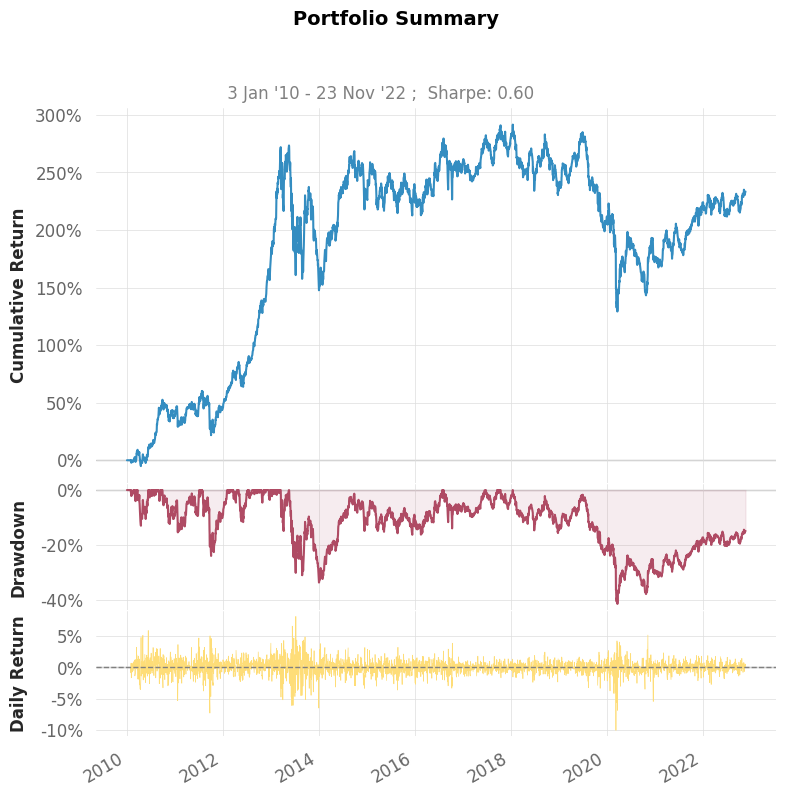

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


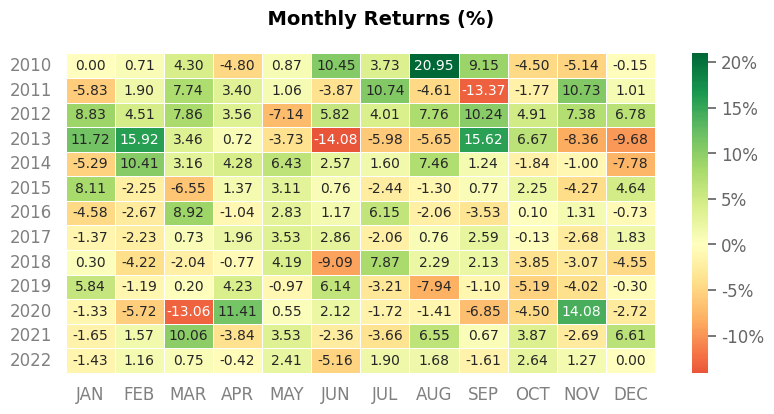

In [ ]:
# netprofit growth QoQ
net_proft_growth_qoq_df = net_profit_df / net_profit_shift_df

# netprofit growth QoQ
net_proft_growth_qoqy_df = net_profit_df / net_profit_shift_4_df
# screening condition
rsi_cond = rsi_df < 30
value_cond = value_df.rolling(window=20).mean() > 2e7  # volume > 2e7

signal_cond = rsi_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)


def screen_net_profit_growth_qoq(
    signal_df: pd.DataFrame, net_proft_growth_qoq_df: pd.DataFrame
) -> pd.DataFrame:
    return pd.DataFrame(
        np.where((signal_df == True), net_proft_growth_qoq_df, np.nan),
        columns=signal_df.columns,
        index=signal_df.index,
    )


def screen_net_profit_growth_qoqy(
    qoq_rank_df: pd.DataFrame, qoq_num: int, net_proft_growth_qoqy_df: pd.DataFrame
) -> pd.DataFrame:
    return pd.DataFrame(
        np.where((qoq_rank_df <= qoq_num), net_proft_growth_qoqy_df, np.nan),
        columns=qoq_rank_df.columns,
        index=qoq_rank_df.index,
    )


# net profit growth(%QoQ) 1 quarter
# 40 highest net profit growth(%QoQ) 1 quarter
qoq_df = screen_net_profit_growth_qoq(signal_df, net_proft_growth_qoq_df)
qoq_rank_df = ssc.rank(factor_df=qoq_df, quantity=40, ascending=False)

# net profit growth(%QoQY) 1 quarter
# 20 highest net profit growth(%QoQY) 1 quarter
qoqy_df = screen_net_profit_growth_qoqy(
    qoq_rank_df=qoq_rank_df,
    qoq_num=10,
    net_proft_growth_qoqy_df=net_proft_growth_qoqy_df,
)
qoqy_rank_df = ssc.rank(factor_df=qoqy_df, quantity=20, ascending=False)
from ezyquant.utils import is_rebalance_monthly

pos_num = 10
signal_trade = (qoqy_rank_df > 0) & (qoqy_rank_df <= pos_num)

# -- rebalance signal --
rebalance_date = is_rebalance_monthly(close_df.index, 31)
signal_trade = signal_trade.mask(~rebalance_date, np.nan)
# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(
    np.where(lookahead_signal == -1, -1, signal_trade),
    columns=signal_trade.columns,
    index=signal_trade.index,
)


## Backtest Algorithm
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0:
        return c.target_pct_port(1 / pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0)  # sell
    return 0


# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)
## Visualization
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(
    summary_df["port_value_with_dividend"], title=f"{UNIVERSE[0]}: {MODEL_NAME}"
)
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])

# SET50

## Solution 1

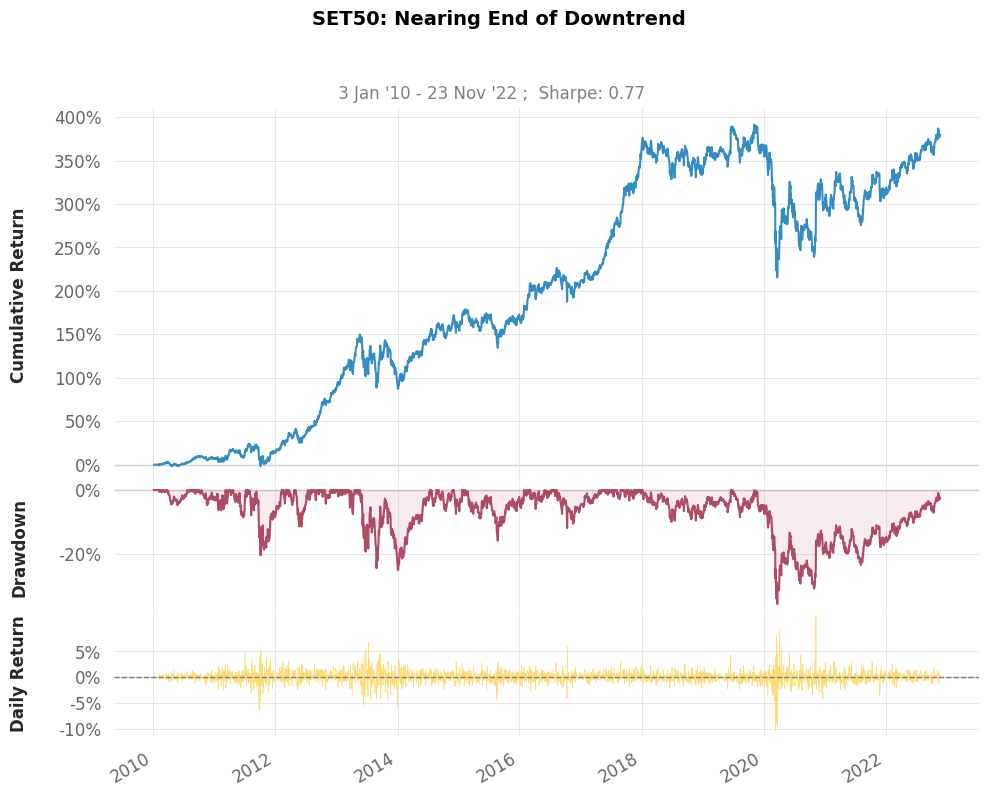

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   379.76%     121.83%
CAGR﹪              12.93%      6.37%

Sharpe              0.78        0.47
Prob. Sharpe Ratio  99.68%      95.09%
Sortino             1.14        0.65
Sortino/√2          0.8         0.46
Omega               1.16        1.16

Max Drawdown        -35.8%      -44.29%
Longest DD Days     1111        1763

Gain/Pain Ratio     0.16        0.09
Gain/Pain (1M)      0.88        0.44

Payoff Ratio        1.0         0.92
Profit Factor       1.16        1.09
Common Sense Ratio  1.2         1.06
CPC Index           0.6         0.54
Tail Ratio          1.04        0.97
Outlier Win Ratio   3.48        4.15
Outlier Loss Ratio  3.85        4.1

MTD                 0.72%       0.97%
3M          

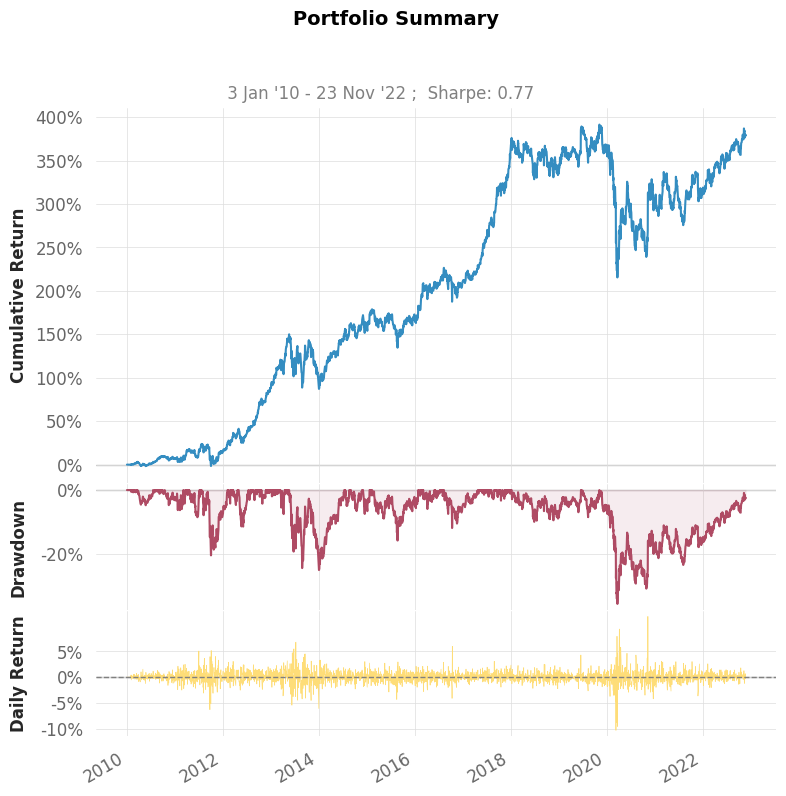

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


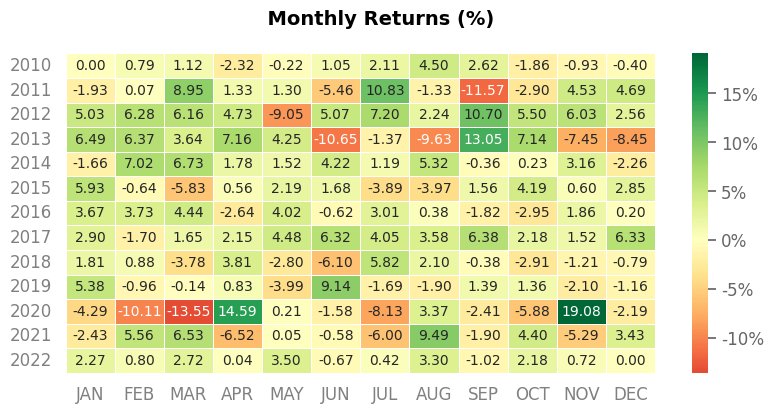

In [ ]:
UNIVERSE = ["SET50"]

ssc = ez.SETSignalCreator(
    start_date=start_data,
    end_date=end_date,
    index_list=UNIVERSE,
)

sdr = _SETDataReaderCached()
# SET INDEX CLOSE
set_index_df = sdr.get_data_index_daily(
    field=fld.D_INDEX_CLOSE,
    index_list=[fld.MARKET_SET],
    start_date=start_data,
    end_date=end_date,
)

# index return
set_index_return = set_index_df.pct_change().fillna(0.0)
MODEL_NAME = "Nearing End of Downtrend"

close_df = ssc.get_data(field="close", timeframe="daily")
value_df = ssc.get_data(field="value", timeframe="daily")
rsi_df = ssc.ta.rsi(close_df, 14)
# netprofit
net_profit_df = ssc.get_data(field="net_profit", timeframe="quarterly")
# netprofit QoQ
net_profit_shift_df = ssc.get_data(field="net_profit", timeframe="quarterly", shift=1)
# netprofit QoQY
net_profit_shift_4_df = ssc.get_data(field="net_profit", timeframe="quarterly", shift=4)

# Netprofit Growth(%QoQ) 1 Quarter
npg_percent_qoq_df = net_profit_df / net_profit_shift_df

# Netprofit Growth(%QoQY) 1 Quarter
npg_percent_qoqy_df = net_profit_df / net_profit_shift_4_df
# screening condition
rsi_cond = rsi_df < 30
npg_percent_qoq_cond = npg_percent_qoq_df > 0
value_cond = value_df.rolling(window=20).mean() > 2e7  # volume > 2e7

signal_cond = rsi_cond & npg_percent_qoq_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)


def screen_npg_percent_qoqy_df(
    signal_df: pd.DataFrame, net_proft_growth_qoq_df: pd.DataFrame
) -> pd.DataFrame:
    return pd.DataFrame(
        np.where((signal_df == True), net_proft_growth_qoq_df, np.nan),
        columns=signal_df.columns,
        index=signal_df.index,
    )


# %netprofit growth QoQy
# 10 highest %netprofit growth QoQy
npg_percent_qoqy_df = screen_npg_percent_qoqy_df(signal_df, npg_percent_qoqy_df)
npg_percent_rank_df = ssc.rank(
    factor_df=npg_percent_qoqy_df, quantity=10, ascending=False
)
from ezyquant.utils import is_rebalance_monthly

pos_num = 10
signal_trade = (npg_percent_rank_df > 0) & (npg_percent_rank_df <= pos_num)

# -- rebalance signal --
rebalance_date = is_rebalance_monthly(close_df.index, 31)
signal_trade = signal_trade.mask(~rebalance_date, np.nan)

# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(
    np.where(lookahead_signal == -1, -1, signal_trade),
    columns=signal_trade.columns,
    index=signal_trade.index,
)


## Backtest Algorithm
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0:
        return c.target_pct_port(1 / pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0)  # sell
    return 0


# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)
## Visualization
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(
    summary_df["port_value_with_dividend"], title=f"{UNIVERSE[0]}: {MODEL_NAME}"
)
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])

## Solution 2

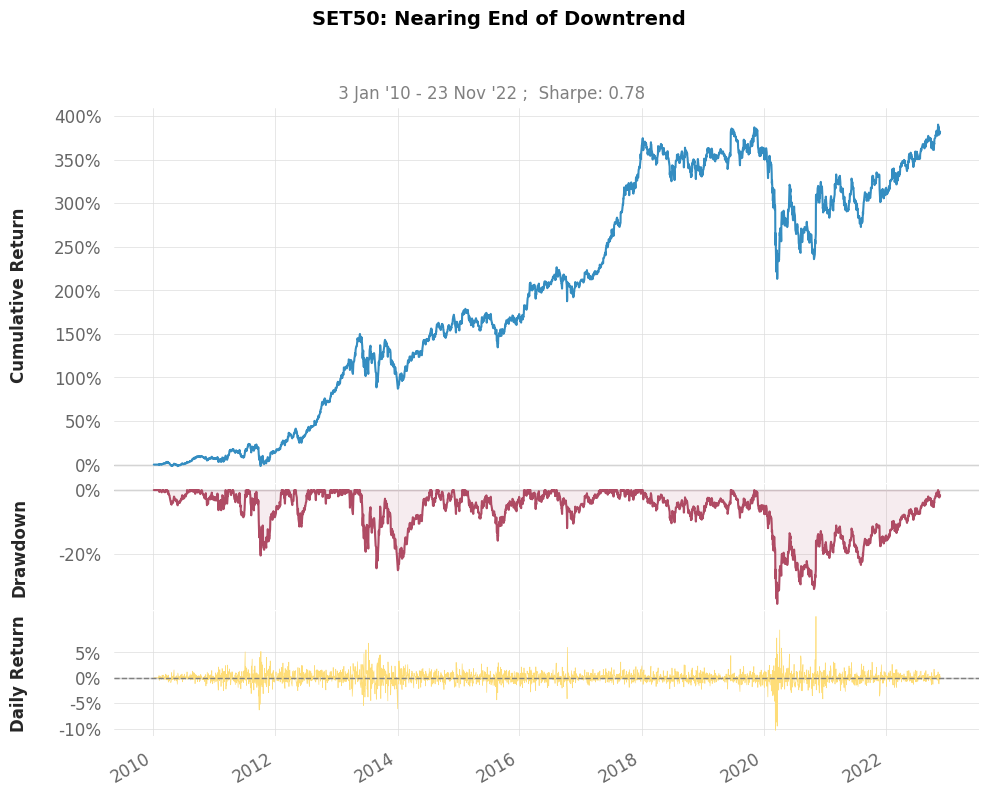

[Performance Metrics]

                    Strategy    Benchmark
------------------  ----------  -----------
Start Period        2010-01-04  2010-01-04
End Period          2022-11-23  2022-11-23
Risk-Free Rate      0.0%        0.0%
Time in Market      100.0%      100.0%

Cumulative Return   382.24%     121.83%
CAGR﹪              12.98%      6.37%

Sharpe              0.78        0.47
Prob. Sharpe Ratio  99.69%      95.09%
Sortino             1.14        0.65
Sortino/√2          0.81        0.46
Omega               1.16        1.16

Max Drawdown        -35.71%     -44.29%
Longest DD Days     1099        1763

Gain/Pain Ratio     0.16        0.09
Gain/Pain (1M)      0.88        0.44

Payoff Ratio        1.0         0.93
Profit Factor       1.16        1.09
Common Sense Ratio  1.2         1.06
CPC Index           0.6         0.55
Tail Ratio          1.04        0.97
Outlier Win Ratio   3.47        4.16
Outlier Loss Ratio  3.87        4.1

MTD                 0.48%       0.97%
3M          

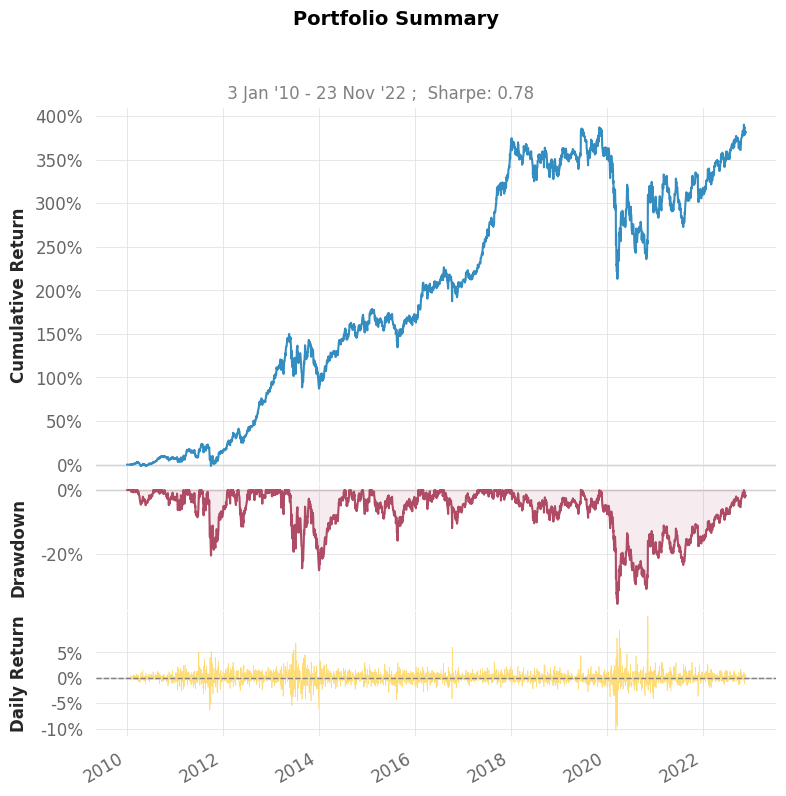

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


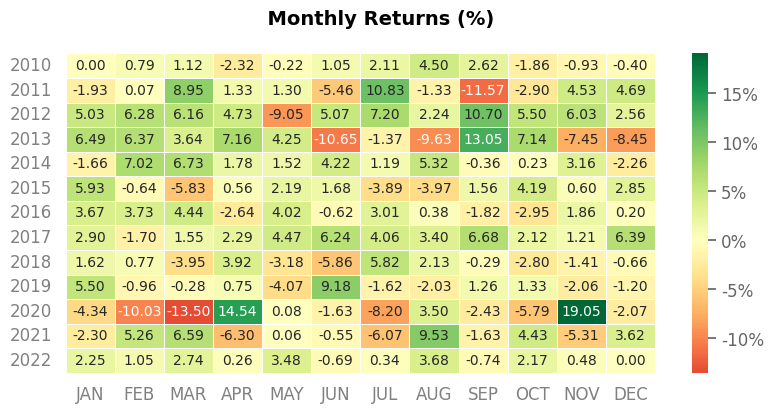

In [ ]:
# netprofit growth QoQ
net_proft_growth_qoq_df = net_profit_df / net_profit_shift_df

# netprofit growth QoQ
net_proft_growth_qoqy_df = net_profit_df / net_profit_shift_4_df
# screening condition
rsi_cond = rsi_df < 30
value_cond = value_df.rolling(window=20).mean() > 2e7  # volume > 2e7

signal_cond = rsi_cond & value_cond

# -- screening universe --
signal_df = ssc.screen_universe(signal_cond, mask_value=np.nan)


def screen_net_profit_growth_qoq(
    signal_df: pd.DataFrame, net_proft_growth_qoq_df: pd.DataFrame
) -> pd.DataFrame:
    return pd.DataFrame(
        np.where((signal_df == True), net_proft_growth_qoq_df, np.nan),
        columns=signal_df.columns,
        index=signal_df.index,
    )


def screen_net_profit_growth_qoqy(
    qoq_rank_df: pd.DataFrame, qoq_num: int, net_proft_growth_qoqy_df: pd.DataFrame
) -> pd.DataFrame:
    return pd.DataFrame(
        np.where((qoq_rank_df <= qoq_num), net_proft_growth_qoqy_df, np.nan),
        columns=qoq_rank_df.columns,
        index=qoq_rank_df.index,
    )


# net profit growth(%QoQ) 1 quarter
# 40 highest net profit growth(%QoQ) 1 quarter
qoq_df = screen_net_profit_growth_qoq(signal_df, net_proft_growth_qoq_df)
qoq_rank_df = ssc.rank(factor_df=qoq_df, quantity=40, ascending=False)

# net profit growth(%QoQY) 1 quarter
# 20 highest net profit growth(%QoQY) 1 quarter
qoqy_df = screen_net_profit_growth_qoqy(
    qoq_rank_df=qoq_rank_df,
    qoq_num=10,
    net_proft_growth_qoqy_df=net_proft_growth_qoqy_df,
)
qoqy_rank_df = ssc.rank(factor_df=qoqy_df, quantity=10, ascending=False)
from ezyquant.utils import is_rebalance_monthly

pos_num = 10
signal_trade = (qoqy_rank_df > 0) & (qoqy_rank_df <= pos_num)

# -- rebalance signal --
rebalance_date = is_rebalance_monthly(close_df.index, 31)
signal_trade = signal_trade.mask(~rebalance_date, np.nan)
# handle sign
lookahead_signal = ssc.screen_universe(signal_trade, mask_value=-1).shift(-2)

final_signal = pd.DataFrame(
    np.where(lookahead_signal == -1, -1, signal_trade),
    columns=signal_trade.columns,
    index=signal_trade.index,
)


## Backtest Algorithm
# -- Backtest Algorithm --
def backtest_algorithm(c: Context):
    if c.volume == 0 and c.signal > 0:
        return c.target_pct_port(1 / pos_num)
    elif c.volume > 0 and c.signal < 0:
        return c.target_pct_port(0)  # sell
    return 0


# -- Backtest Setting --
result = ez.backtest(
    signal_df=final_signal,
    backtest_algorithm=backtest_algorithm,
    start_date=start_date,
    end_date=end_date,
    initial_cash=1e8,
    pct_commission=0.25,
    pct_buy_slip=0.01,
    pct_sell_slip=0.01,
    price_match_mode="weighted",
    signal_delay_bar=1,
)
## Visualization
summary_df = result.summary_df.set_index("timestamp")

qs.plots.snapshot(
    summary_df["port_value_with_dividend"], title=f"{UNIVERSE[0]}: {MODEL_NAME}"
)
qs.reports.basic(summary_df["port_value_with_dividend"], set_index_return["SET"])